# Replicating signal processing in other papers using CTU-CHB dataset in deep learning models

## Set-up

In [1]:
# Import packages
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy import signal

## Bursa and Lhotska et al. 2017
* Example uses record 1001 with no filtering or artifact removal
* Morlet wavelet with "w" or "ω" (omega) parameter as 4 or 8
* Scaleogram y axis includes:
    * 10 to the power of 0 = 1
    * 10 to the power of -1 = 1/10
    * 10 to the power of -2 = 1/100
* Given that scale and frequency are inversely proportional, I'm presuming this is likely plotting frequencies and so:
    * Frequency 1 = 1
    * Frequency 1/10 = 10
    * Frequency 1/100 = 100
* It appears to be a on a logarithmic scale
* Scaleogram plots are 5000 to 19000. Signal plots have no x axis

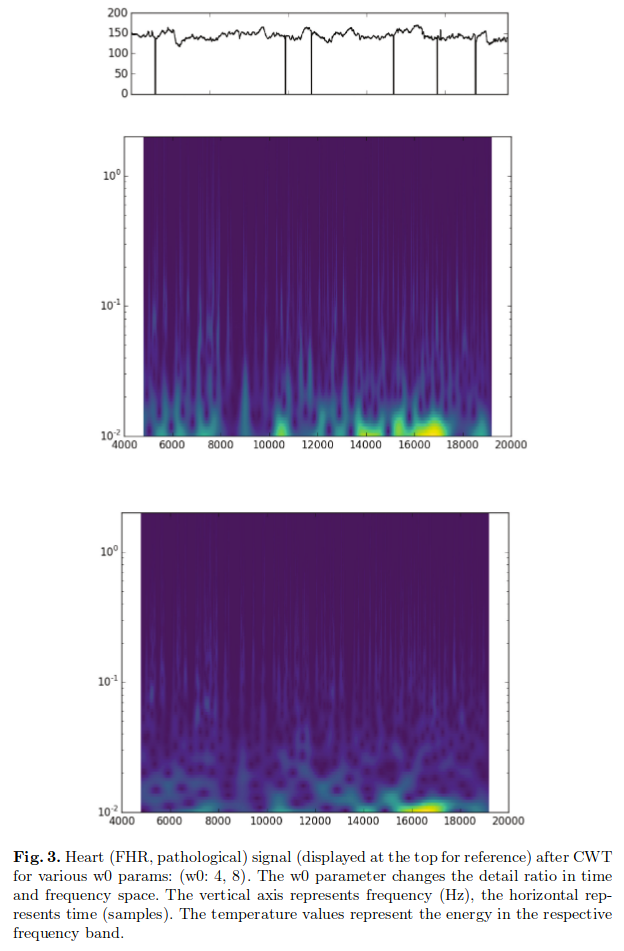

In [2]:
# Source: https://link.springer.com/chapter/10.1007/978-3-319-64265-9_9
Image('images/bursa_figure3.png')

It is unclear why this looks so different to their signal, since it is using the same record and time points with no other changes to the signal.

Text(0, 0.5, 'FHR (bpm)')

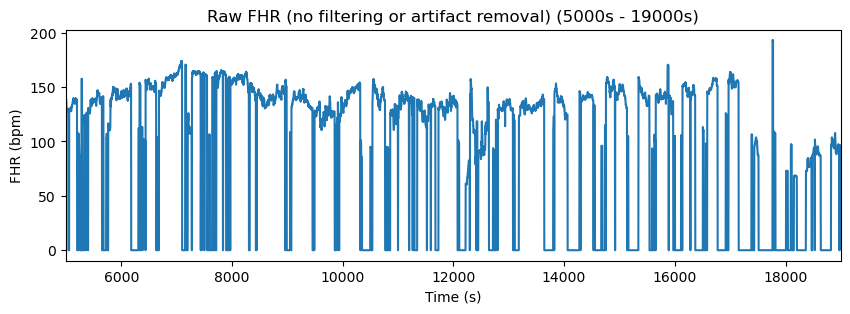

In [3]:
# Import the matching data
ctg = pd.read_csv('data_csv/1001.csv')
raw_fhr = ctg['FHR']

# Trim it to the same time range as in the figure
trim_fhr = raw_fhr[5000:19001]

# Plot the signal
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(trim_fhr)
ax.margins(x=0)
ax.set_title('Raw FHR (no filtering or artifact removal) (5000s - 19000s)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('FHR (bpm)')

Morlet wavelet parameters:
* **Wavelet width - "σ" or "width" or "s":** Determines spread of wavelet in time domain (relates to scale/frequency)
* **Wavelet length - "M":** Relates to number of oscillations in wavelet, adjusting length impacts width and vice versa (e.g. longer wavelet may be more appropriate for signals with slower oscillations).
* **Scale/frequency - "w" or "ω" (omega):** Determines wavelet frequency. Definition varies depending on implementation - e.g. sometimes given in cycles per unit time, sometimes its angular frequency (how quickly wave oscillates)

However I'm not sure what the values are, only that w= 4 or 8, but can't input those without M and S for morlet2, so for now, just created with default signal.morlet2.

In [4]:
# Generate a log scale from 1 to 100
log_scale = np.logspace(0, 2, num=100)

# Print the values
print(log_scale)

[  1.           1.04761575   1.09749877   1.149757     1.20450354
   1.26185688   1.32194115   1.38488637   1.45082878   1.51991108
   1.59228279   1.66810054   1.7475284    1.83073828   1.91791026
   2.009233     2.10490414   2.20513074   2.3101297    2.42012826
   2.53536449   2.65608778   2.7825594    2.91505306   3.05385551
   3.19926714   3.35160265   3.51119173   3.67837977   3.85352859
   4.03701726   4.22924287   4.43062146   4.64158883   4.86260158
   5.09413801   5.33669923   5.59081018   5.85702082   6.13590727
   6.42807312   6.73415066   7.05480231   7.39072203   7.74263683
   8.11130831   8.49753436   8.90215085   9.32603347   9.77009957
  10.23531022  10.72267222  11.23324033  11.76811952  12.32846739
  12.91549665  13.53047775  14.17474163  14.84968262  15.55676144
  16.29750835  17.07352647  17.88649529  18.73817423  19.6304065
  20.56512308  21.5443469   22.5701972   23.64489413  24.77076356
  25.95024211  27.18588243  28.48035868  29.8364724   31.2571585
  32.7454916

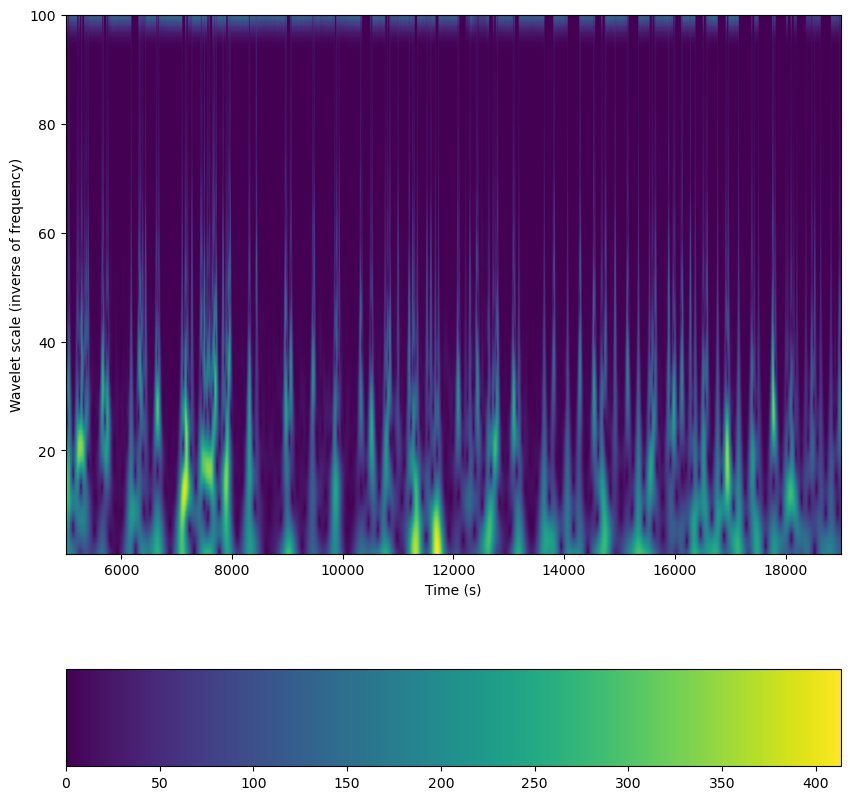

In [5]:
# Perform CWT
cwtmatr = signal.cwt(trim_fhr, signal.morlet2, log_scale)

# Find absolute values
magn = np.absolute(cwtmatr)

# Plot scaleogram
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(
    magn,
    extent=[min(trim_fhr.index), max(trim_fhr.index), 1, 100],
    aspect='auto',)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Wavelet scale (inverse of frequency)')
plt.colorbar(im, ax=ax, orientation='horizontal', aspect=8)
plt.show()

## Comert and Kocamaz 2018

Pre-processing:
* Remove gaps greater than 15s
* Using cubic spine interpolation to fill small gaps
* Use standard median filter to lightly soften (with loss of variability)
* Use outlier detection algorithm from Romano, M., Faiella, G., Bifulco, P., D’Addio, G., Clemente, F., Cesarelli, M.: Outliers detection and processing in CTG monitoring. In: Roa Romero, L.M. (ed.) XIII Mediterranean Conference on Medical and Biological Engineering and Computing 2013, MEDICON 2013, Seville, Spain, 25–28 September 2013, pp. 651–654. Springer, Cham (2014). This algorithm involves detection of local outliers (cardiac arrhythmias and short time artifacts) and global outliers (signal losses). Local outliers are from forward and backward scan of signal with 2 different thresholds according to signal quality, where outlier exceeds threshold with reference value being median on five samples (?). Global outliers are preceded and followed by intervals with opposite monotony
* De-trend signal (as using non-linear techniques, so want to preserve dynamics in nature of FHR signals)

Transformation:
* Short Time Fourier Transform (STFT)
* Use four frequency intervals: 0-0.03Hz, 0.03-0.15Hz, 0.15-0.5Hz, and 0.5-1Hz. These intervals are associated with some physical events - lower frequency are fetal maturation, moderate frequency are fetal movements and maternal respiration, and high frequency are parasympathetic nervous system fluctuations.

Not sure:
* What record is used to produce the example figures
* What parameters were used for spectogram generation

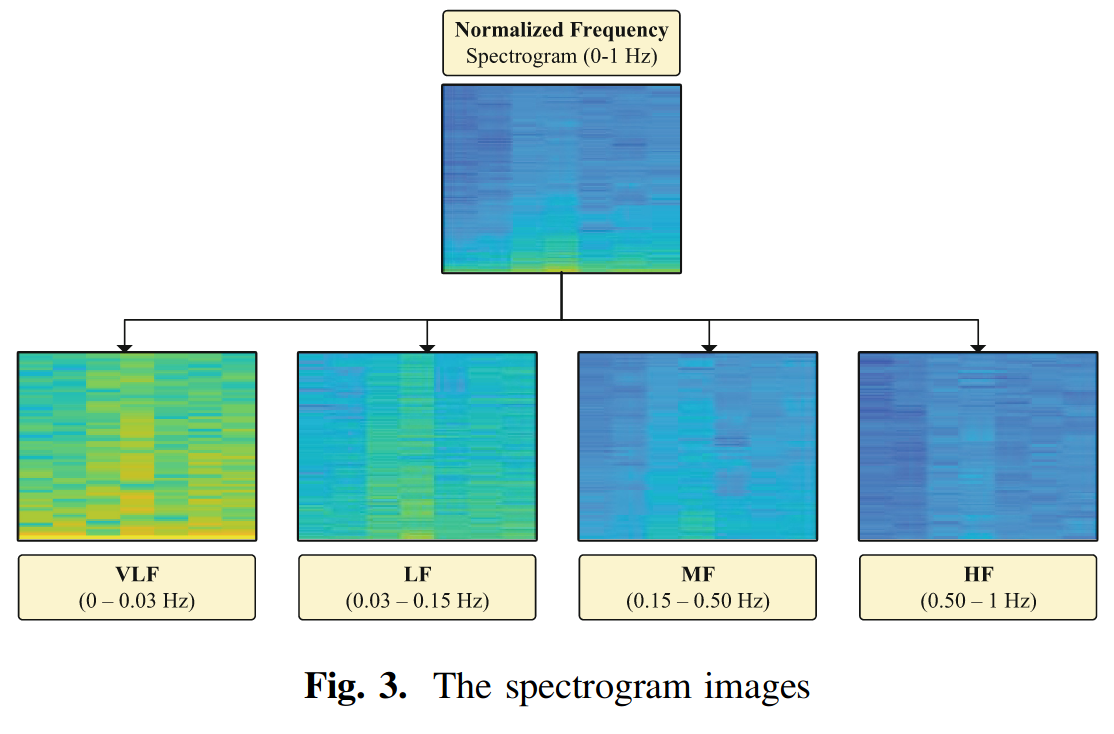

In [6]:
Image('images/comert_figure3.png')

In [7]:
# Import some FHR data
ctg = pd.read_csv('data_csv/1001.csv')
raw_fhr = ctg['FHR']

Using my current cleaning function - doesn't match their whole process

In [8]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Clip to last 90 minutes
    fhr = fhr.tail(90*60)

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    return(fhr)


fhr = clean_fhr(raw_fhr)

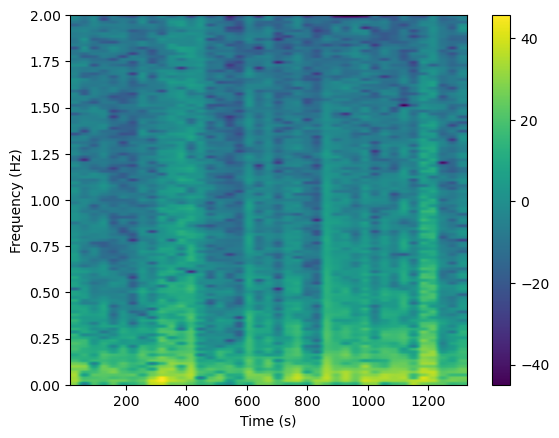

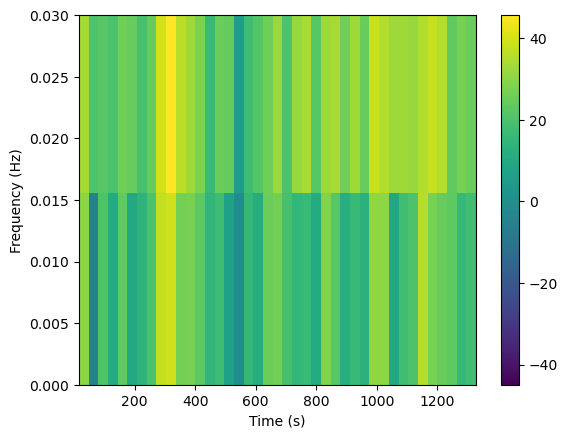

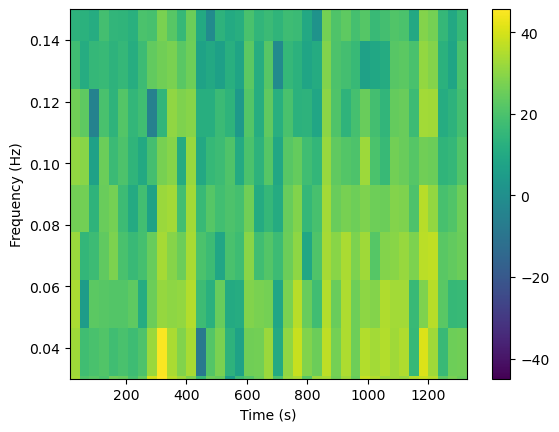

In [9]:
plt.specgram(fhr, NFFT=256, Fs=4, detrend='linear')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.specgram(fhr, NFFT=256, Fs=4, detrend='linear')
plt.colorbar()
plt.ylim(0, 0.03)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.specgram(fhr, NFFT=256, Fs=4, detrend='linear')
plt.colorbar()
plt.ylim(0.03, 0.15)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Daydulo et al. 2022

Signal pre-processing:
* Long gaps (more than 15s) removed from the signal
* Missing values at beginning and end of recording excluded to start from the stable point
* Outside 50bpm or 200bpm are outliers
* Outliers and small gaps were find and linearly interpolated using Matlab
* Spikes are when beat is more than 25 from previous adjacent beat (not physiologic, unreliable) so removed using cubic spline interpolation.

Selected segment of the first 20 minutes (4800) and last 15 minutes (3600) to use and represent first and second stage of labour

CWT:
* Generalised Morse wavelet
* Sampling frequency 4 Hz
* Signal length (4800 and 3600) gamma (γ) parameter 3
* Time bandwidth product (P-squared) value 60, 55
* Voice for octave value of 12

Not sure:
* Which record used for creation of figures

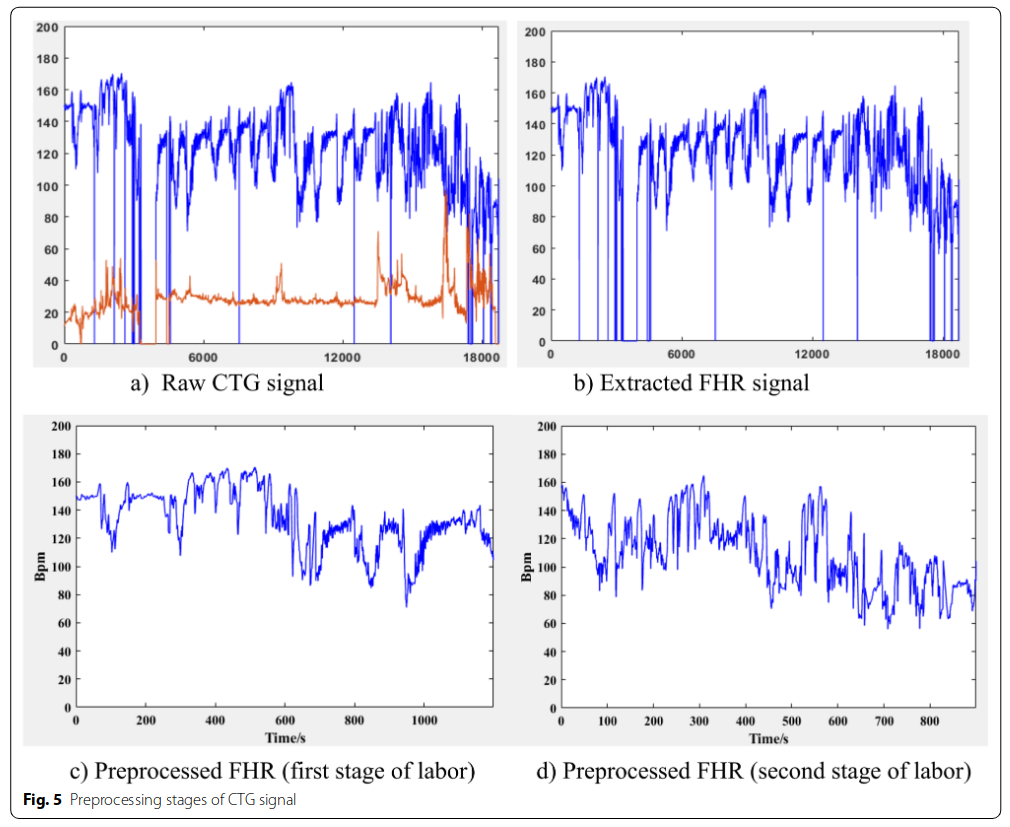

In [10]:
Image('images/daydulo_figure5.png')

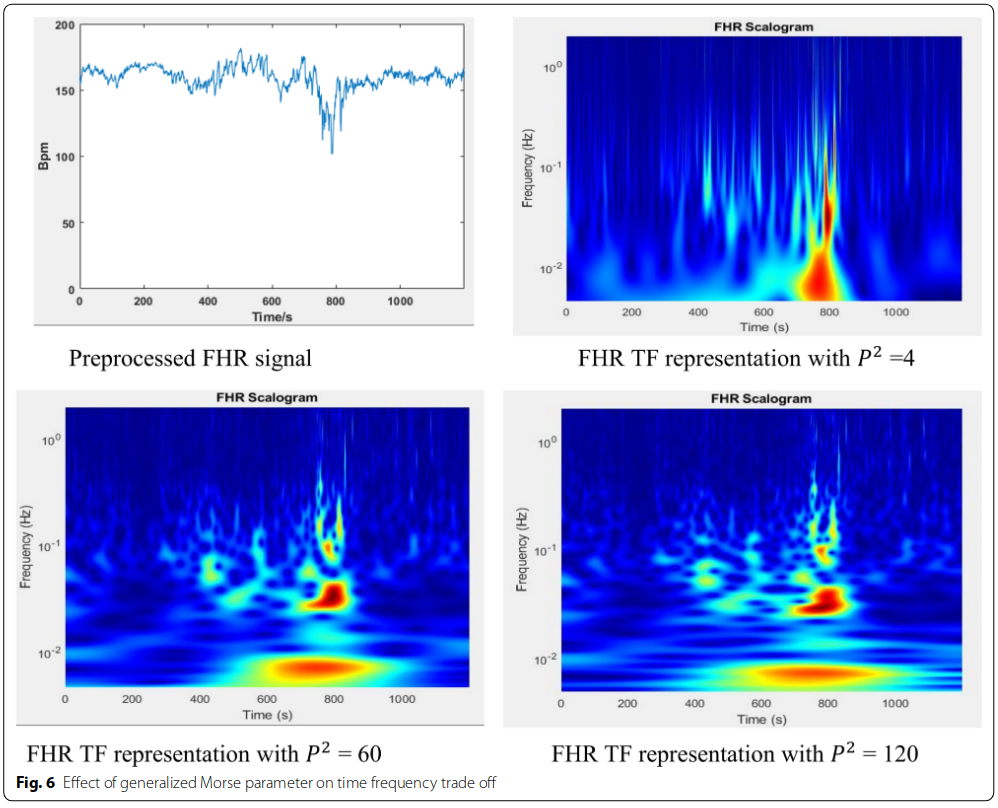

In [11]:
Image('images/daydulo_figure6.png')

In [12]:
# Import some FHR data
ctg = pd.read_csv('data_csv/1001.csv')
raw_fhr = ctg['FHR']

In [13]:
def daydulo_clean(fhr):
    '''
    Cleans fetal heart rate (FHR) signal according to Daydulo et al. 2022
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    '''

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using cubic interpolation
    fhr = fhr.interpolate(method='cubic')

    return(fhr)

In [14]:
# Clean the FHR
fhr = daydulo_clean(raw_fhr)

# Extract first 20 minutes (4800) and last 15 minutes (3600)
fhr_first = fhr.head(20*60)
fhr_second = fhr.tail(15*60)

The first stage signal appears reasonably similar to the paper, the second stage does not.

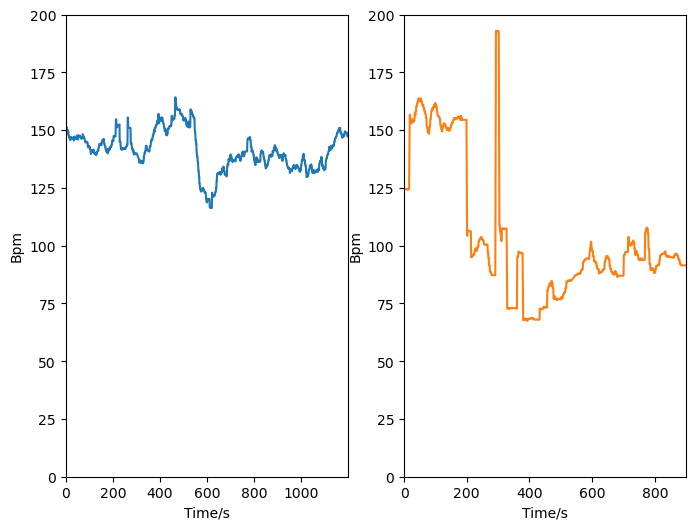

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))

ax[0].plot(fhr_first)
ax[0].margins(x=0)
ax[0].set_ylim(0, 200)
ax[0].set_xlabel('Time/s')
ax[0].set_ylabel('Bpm')

ax[1].plot(fhr_second.reset_index())
ax[1].margins(x=0)
ax[1].set_ylim(0, 200)
ax[1].set_xlabel('Time/s')
ax[1].set_ylabel('Bpm')

plt.show()

Haven't been able to input the described parameters, but putting into standard morlet, only thing we're seeing is the boundary effects.

Text(0, 0.5, 'Scale')

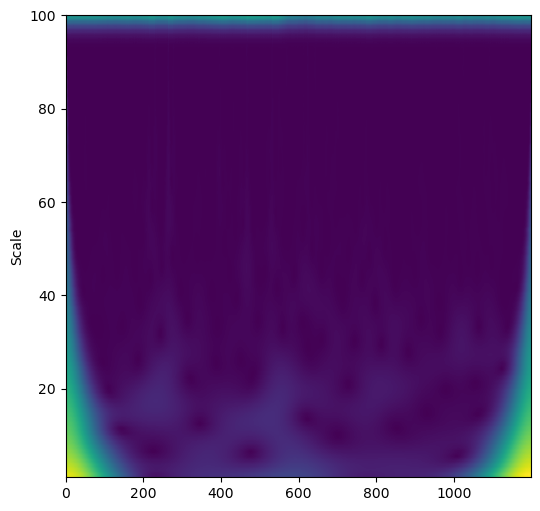

In [16]:
# Generate a log scale from 1 to 100
log_scale = np.logspace(0, 2, num=100)

# Perform CWT with Morlet and plot
cwtmatr = signal.cwt(fhr_first, signal.morlet2, log_scale)

# Plot the scaleogram
fig, ax = plt.subplots(figsize=(6, 6))
magn = np.abs(cwtmatr)
ax.imshow(magn,
          extent=[min(fhr_first.index), max(fhr_first.index), 1, 100],
          aspect='auto')
ax.set_ylabel('Scale')